In [1]:
#Import necessary library case uts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def potential(xmin, xmax):
  '''
  Set harmonic oscillator potential within the system
  Input   : x interval
  Return  : potential
  '''

  #Morse potential
  D = 1
  alpha = 0.1
  potential_v = D * (1 - np.exp(-alpha * xmin))**2

  return potential_v

In [3]:
def normalize(n, h, psi):
  '''
  Normalize wave function
  Input   : initial wave function, number of points, step
  Return  : normalized wave function
  '''
  norm = psi[0]**2+psi[n]**2
  for i in range(1,n-3,2):
    norm = norm+4*psi[i]**2+2*psi[i+1]**2

  norm = norm + 4*psi[n-1]**2
  norm = 1/np.sqrt((norm*h/3))

  for i in range(0, len(psi)):
   psi[i] = psi[i]*norm

  return psi

In [4]:
def numerov(nx, x, e_init, psi):
  '''
  Integrates the wave function using Numerov's method
  Input   : number of points, x inteval, initial energy, wave function
  Return  : integrated wave function
  '''

  #Calculates the steps
  h = xmax/nx
  h2 = h**2
  h12 = h2/12

  #Initialize wave function
  psi[0] = 0
  psi[1] = 0.0001

  #Calculates using Numerov's nethod
  fn = 2*(potential(-x, x)-e_init)
  q0 = psi[0]*(1-h12*fn)
  fn = 2*(potential(-x+h, x)-e_init)
  q1 = psi[1]*(1-h12*fn)
  
  for n in range(2, 2*nx+1):
    q2 = h2*fn*psi[n-1]+2*q1-q0
    fn = 2*(potential(n*h-x, x)-e_init)
    psi[n] = q2/(1-h12*fn)
    q0 = q1
    q1 = q2

  psi = normalize(2*nx, h, psi)

  return psi

In [5]:
def calculates(nx, x, e_init, de, eps, psi):
  '''
  Starting course search and approximate energy level using bisection method
  Input   : number of points, x inteval, initial energy,
            eps, lists to store energy and deviation
  Return  : Energy approximation, wave function
  '''
  #Starting course search
  psi = numerov(nx, x, e_init, psi)
  dev1 = psi[2*nx]

  while True:
    #Update energy with de step
    e2 = e_init + de
 
    psi = numerov(nx, x, e2, psi)
    dev2 = psi[2*nx]

    #Check if deviation is zero
    if dev1*dev2 < 0:
      break

    #Update energy and deviation value for next iteration  
    e_init = e2
    dev1 = dev2

  #Starting bisection
  while abs(e_init-e2) > eps:
    e3 = (e_init+e2)/2
    psi = numerov(nx,x,e3,psi)
    dev3 = psi[2*nx]

    if dev3*dev1 <= 0.000000 :
      e2 = e3
      dev2 = dev3
    else:
      e_init = e3
      dev2 = dev3

  return e3, psi

In [6]:
def schrod(nx, xmax, e0, de, filename, n):
  '''
  Function to calculates energy and wave function
  Input   : number of points, x interval, initial energy, delta e, filename, energy level
  Return  : approximated energy, psi .date file
  '''
  #Initialize Parameters
  eps = 10e-6
  dx = xmax/nx

  #Initialize wave function
  psi = np.zeros(2*nx+1)

  #Calculates energy and deviation
  energy, psi = calculates(nx, xmax, e0, de, eps, psi)

  #Save output as dat file
  filename = filename + str(n) + '.dat'
  x = np.zeros(2*nx+1)
  for i in range(1, 2*nx+2):
    x[i-1] = (i-1)*dx-xmax
    
  with open(filename, 'w') as out_file:
    for item in range(len(psi)):
      # out_file.write(str(x[item]) + '      ' + (psi[item]) + '\n')
      out_file.write("{}      {}      \n".format(x[item], psi[item]))

  return energy

In [14]:
#Initialize Parameters
nx = 100
xmax = 30 #L = 10
e0 = 0
de = 0.001
energy_level = [i for i in range(0, 11)]
energy_value = []
filename = 'psi-out'

for i in energy_level:
  energy = schrod(nx, xmax, e0, de, filename, i)
  energy_value.append(energy)

  #Update for the next energy level
  e0 = energy + 0.005

In [22]:
def analytics(n):
  '''
  Analytical value of morse potential
  Input   : energy level
  Return  : energy value
  '''
  D = 1
  alpha = 0.1
  s = (np.sqrt(2*D)/alpha) - 0.5
  ana_value = []
  for i in range(n):
    ana = D - ((alpha**2) / 2)*(s - i)**2
    ana_value.append(ana)

  return ana_value

In [24]:
#Make dataframe to store energy

output = pd.DataFrame(columns=['Energy Level', 'Energy (a.u.)', 'Analytics', 'Error'])


energy_analytics = analytics(len(energy_level))

for i in range(len(energy_level)):
  output.loc[i] = [energy_level[i], energy_value[i], energy_analytics[i], abs(energy_analytics[i]-energy_value[i])]

output

,Energy Level,Energy (a.u.),Analytics,Error
0,0.0,0.069461,0.069461,2.593813e-07
1,1.0,0.200875,0.200882,7.034356e-06
2,2.0,0.322305,0.322303,1.296907e-06
3,3.0,0.433719,0.433725,5.996831e-06
4,4.0,0.535148,0.535146,2.334432e-06
5,5.0,0.626563,0.626567,4.959305e-06
6,6.0,0.693617,0.707989,1.437163e-02
7,7.0,0.707984,0.779410,7.142580e-02
8,8.0,0.779414,0.840832,6.141747e-02
9,9.0,0.841484,0.892253,5.076851e-02


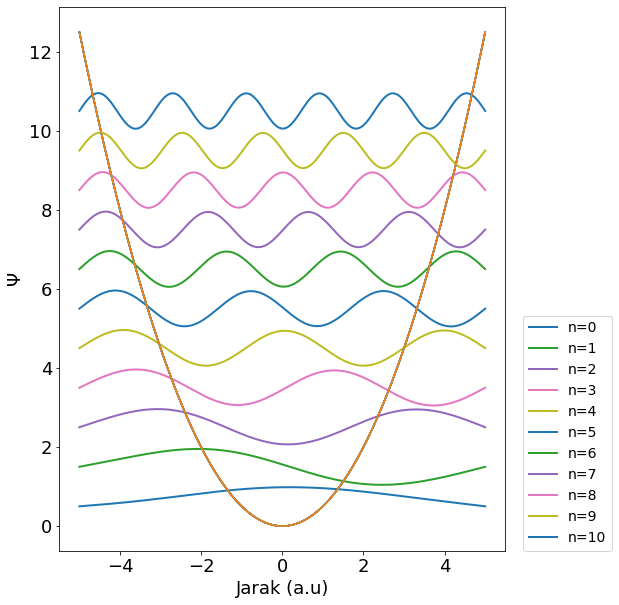

In [9]:
#Plot wave function

filename = 'psi-out'

fig, ax = plt.subplots(figsize=(8, 10))

for n in range(0, 11):
  data = np.loadtxt(filename+str(n)+'.dat', unpack=True)
  x_pos = data[0]
  psii = data[1]

  plt.plot(x_pos, psii + (n+0.5), label='n='+str(n), linewidth=2)
  plt.plot(x_pos, 1/2*x_pos*x_pos)

plt.xlabel('Jarak (a.u)', fontsize=18)
plt.ylabel('$\Psi$', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0, fontsize=14)
plt.show()